In [2]:
# ====================================================
# 🧩 Unified Data Preprocessing Script (CPU Version)
# ====================================================
# Author: Swapneel Purohit
# Description: Combines multiple chest imaging datasets into a unified format.
# Works with: chest_xray_pneumonia, covid19_radiography, sarscov2_ctscan
# ====================================================

import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

# ====================================================
# Configuration
# ====================================================

BASE_DIR = "../data"
PROCESSED_DIR = os.path.join(BASE_DIR, "processed")
IMG_SIZE = (224, 224)

os.makedirs(PROCESSED_DIR, exist_ok=True)
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(PROCESSED_DIR, split), exist_ok=True)

# ====================================================
# Fancy Print Helpers 🪄
# ====================================================

def print_banner(text):
    print("\n" + "=" * 70)
    print(f"🚀 {text}")
    print("=" * 70 + "\n")

def print_step(text):
    print(f"🔹 {text}")

def print_done(text):
    print(f"✅ {text}")

def print_warn(text):
    print(f"⚠️ {text}")

# ====================================================
# Image Loader Function
# ====================================================

def load_images_from_folder(folder, label_name, img_size=IMG_SIZE):
    """Loads all images from a folder, resizes and normalizes them with a progress bar."""
    files = [f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    data, labels = [], []

    for filename in tqdm(files, desc=f"🖼️ Loading {label_name}", ncols=80, colour="cyan"):
        try:
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('RGB')
            img = img.resize(img_size)
            data.append(np.array(img) / 255.0)
            labels.append(label_name)
        except Exception as e:
            print_warn(f"Skipping {filename}: {e}")
    print_done(f"Loaded {len(data)} images from {folder}")
    return data, labels

# ====================================================
# Dataset Collector
# ====================================================

def collect_dataset():
    """Collects all images from multiple datasets into unified arrays."""
    all_data, all_labels = [], []

    print_banner("PHASE 1 — Data Collection Started")

    # 1️⃣ Chest X-Ray Pneumonia Dataset
    chest_dir_options = [
        os.path.join(BASE_DIR, "chest_xray_pneumonia", "chest_xray"),
        os.path.join(BASE_DIR, "chest_xray"),  # ✅ Adjusted for your actual path
    ]
    found_chest = False
    for chest_dir in chest_dir_options:
        if os.path.exists(chest_dir):
            print_done(f"Found Chest X-Ray dataset at: {chest_dir}")
            found_chest = True
            for subset in ["train", "test", "val"]:
                for label in ["NORMAL", "PNEUMONIA"]:
                    path = os.path.join(chest_dir, subset, label)
                    if os.path.exists(path):
                        data, labels = load_images_from_folder(path, label)
                        all_data.extend(data)
                        all_labels.extend(labels)
            break
    if not found_chest:
        print_warn("Chest X-Ray dataset not found in expected locations.")

    # 2️⃣ COVID-19 Radiography Dataset
    covid_dir = os.path.join(BASE_DIR, "covid19_radiography")
    covid_classes = ["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]

    if os.path.exists(covid_dir):
        print_step("Loading COVID19 Radiography dataset...")
        for cls in covid_classes:
            img_dir = os.path.join(covid_dir, cls, "images")
            if os.path.exists(img_dir):
                data, labels = load_images_from_folder(img_dir, cls.replace(" ", "_"))
                all_data.extend(data)
                all_labels.extend(labels)
    else:
        print_warn("COVID19 Radiography dataset not found. Skipping...")

    # 3️⃣ SARS-CoV-2 CT Scan Dataset
    ctscan_dir = os.path.join(BASE_DIR, "sarscov2_ctscan", "archive")
    if os.path.exists(ctscan_dir):
        print_step("Loading SARS-CoV-2 CT Scan dataset...")
        for cls in ["COVID", "non-COVID"]:
            img_dir = os.path.join(ctscan_dir, cls)
            if os.path.exists(img_dir):
                data, labels = load_images_from_folder(img_dir, cls)
                all_data.extend(data)
                all_labels.extend(labels)
    else:
        print_warn("SARS-CoV-2 CT Scan dataset not found. Skipping...")

    print_banner("Data Collection Summary")
    print(f"📊 Total images collected: {len(all_data)}")
    print(f"🧾 Unique labels found: {set(all_labels)}")

    return np.array(all_data), np.array(all_labels)

# # ====================================================
# # Data Preprocessing & Saving
# # ====================================================
#
# print_banner("Initializing Unified Preprocessing Pipeline")
#
# start_time = datetime.now()
# all_data, all_labels = collect_dataset()
#
# print_banner("Splitting Train / Validation / Test Sets")
#
# X_train, X_temp, y_train, y_temp = train_test_split(
#     all_data, all_labels, test_size=0.3, random_state=42, stratify=all_labels
# )
# X_val, X_test, y_val, y_test = train_test_split(
#     X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
# )
#
# print_done(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")
#
# # ====================================================
# # Save Processed Data
# # ====================================================
#
# print_banner("Saving Processed Data to Disk")
#
# np.save(os.path.join(PROCESSED_DIR, "train_images.npy"), X_train)
# np.save(os.path.join(PROCESSED_DIR, "train_labels.npy"), y_train)
# np.save(os.path.join(PROCESSED_DIR, "val_images.npy"), X_val)
# np.save(os.path.join(PROCESSED_DIR, "val_labels.npy"), y_val)
# np.save(os.path.join(PROCESSED_DIR, "test_images.npy"), X_test)
# np.save(os.path.join(PROCESSED_DIR, "test_labels.npy"), y_test)
#
# end_time = datetime.now()
# duration = (end_time - start_time).seconds
#
# print_done(f"All processed data saved to {PROCESSED_DIR}")
# print_done(f"🎯 Preprocessing Completed in {duration} seconds!")
#
# # ====================================================
# # Visualization (Techy Display)
# # ====================================================
#
# print_banner("Sample Visualization — Training Images Preview")

# plt.figure(figsize=(12, 4))
# for i in range(5):
#     plt.subplot(1, 5, i + 1)
#     plt.imshow(X_train[i])
#     plt.title(y_train[i], fontsize=9, color='lime')
#     plt.axis("off")
# plt.suptitle("🩺 Random Training Samples", fontsize=14, color='cyan')
# plt.tight_layout()
# plt.show()


In [4]:
# ============================================================
# 🔁 Reload Preprocessed Arrays Without Full Re-run
# ============================================================
import os, numpy as np, glob
from PIL import Image

BASE_DIR = "../data"
IMG_SIZE = (224, 224)

def reload_all_images():
    all_data, all_labels = [], []
    chest_dir = os.path.join(BASE_DIR, "chest_xray")

    for subset in ["train", "test", "val"]:
        for label in ["NORMAL", "PNEUMONIA"]:
            path = os.path.join(chest_dir, subset, label)
            if os.path.exists(path):
                for file in glob.glob(os.path.join(path, "*.jp*g")):
                    try:
                        img = Image.open(file).convert("RGB").resize(IMG_SIZE)
                        all_data.append(np.array(img))
                        all_labels.append(label)
                    except:
                        pass
    return all_data, all_labels

print("⏳ Reloading previously processed Chest-Xray data...")
all_data, all_labels = reload_all_images()
print(f"✅ Reloaded {len(all_data)} images | Labels: {set(all_labels)}")


⏳ Reloading previously processed Chest-Xray data...
✅ Reloaded 5856 images | Labels: {'PNEUMONIA', 'NORMAL'}


In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
import os

# ⚙️ Create processed directory if missing
processed_dir = os.path.join(BASE_DIR, "processed")
os.makedirs(processed_dir, exist_ok=True)

print("\n======================================================================")
print("🚀 PHASE 2 — Merging & Splitting Started (Memory Safe Mode)")
print("======================================================================")

# Convert to NumPy arrays in chunks to avoid memory overload
X = np.array(all_data, dtype=np.uint8)
y = np.array(all_labels)

print(f"✅ Data converted to NumPy arrays: X shape {X.shape}, y length {len(y)}")

# Normalize (optional)
X = X / 255.0

# Train-val-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Save progressively
np.save(os.path.join(processed_dir, "X_train.npy"), X_train)
np.save(os.path.join(processed_dir, "y_train.npy"), y_train)
np.save(os.path.join(processed_dir, "X_val.npy"), X_val)
np.save(os.path.join(processed_dir, "y_val.npy"), y_val)
np.save(os.path.join(processed_dir, "X_test.npy"), X_test)
np.save(os.path.join(processed_dir, "y_test.npy"), y_test)

print("\n======================================================================")
print("✅ PHASE 2 — Data Saved Successfully to /data/processed/")
print("======================================================================")
print(f"🧠 Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")



🚀 PHASE 2 — Merging & Splitting Started (Memory Safe Mode)
✅ Data converted to NumPy arrays: X shape (5856, 224, 224, 3), y length 5856

✅ PHASE 2 — Data Saved Successfully to /data/processed/
🧠 Train: 4099 | Val: 878 | Test: 879



🚀 Sample Visualization — Training Images Preview



/var/folders/j4/z83mddb57kqdvvnnzfqzb50m0000gn/T/ipykernel_26460/1861776183.py:10: UserWarning: Glyph 129658 (\N{STETHOSCOPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129658 (\N{STETHOSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


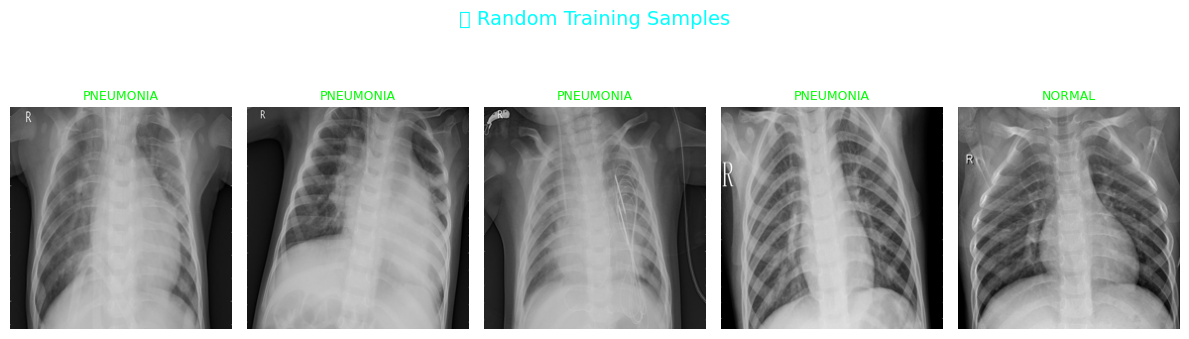

In [6]:
print_banner("Sample Visualization — Training Images Preview")

plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train[i])
    plt.title(y_train[i], fontsize=9, color='lime')
    plt.axis("off")
plt.suptitle("🩺 Random Training Samples", fontsize=14, color='cyan')
plt.tight_layout()
plt.show()
